### Churn Modelling EDA 

In [1]:
# Import the required modules

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV
import xgboost

from sklearn.model_selection import cross_val_score

In [2]:
dtset = pd.read_csv('../datasets/Churn_Modelling.csv')
dtset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# Let's check for missing values if any

dtset.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [4]:
dtset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Dataset looks good to go

In [5]:
# Get dummy variables for the categorical features

geography = pd.get_dummies(dtset['Geography'], drop_first=True)
gender = pd.get_dummies(dtset['Gender'], drop_first=True)

Text(0.5, 1.0, 'Number of Exited (0 for No, 1 for Yes)')

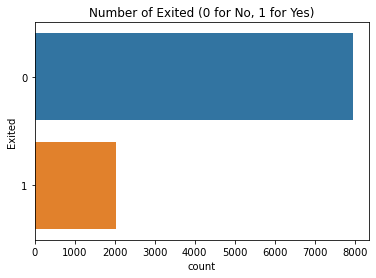

In [6]:
# Compare the number of Exited and number of people who didn't 

sns.countplot(y='Exited', data=dtset)
plt.title('Number of Exited (0 for No, 1 for Yes)')

In [7]:
# Check the percentage to check if the data is imbalanced

n_0 = dtset[dtset['Exited'] == 0].shape[0]
n_1 = dtset[dtset['Exited'] == 1].shape[0]
percentg_0 = n_0/len(dtset['Exited']) * 100.0
percentg_1 = n_1/len(dtset['Exited']) * 100.0
print("0 : {}, 1 : {}".format(percentg_0, percentg_1))

0 : 79.63, 1 : 20.369999999999997


Data won't be called imbalanced

Text(0, 0.5, 'Has a Credit Card')

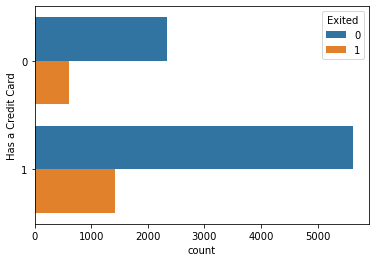

In [8]:
sns.countplot(y='HasCrCard', data=dtset, hue='Exited')
plt.ylabel('Has a Credit Card')

<AxesSubplot:xlabel='count', ylabel='NumOfProducts'>

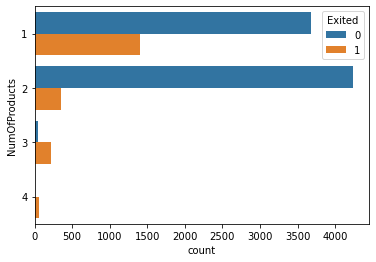

In [9]:
sns.countplot(y='NumOfProducts', data=dtset, hue='Exited')

So, if the number of products are more than 2. They are most likely to churn.

In [10]:
def numeric_hist(feature, kde, hist):
    plt.figure(figsize=(8,5))
    ax0 = sns.distplot(dtset[dtset['Exited']==0][feature], kde=kde, hist=hist, kde_kws={'linewidth':3}, label='Churn: No')
    ax1 = sns.distplot(dtset[dtset['Exited']==1][feature], kde=kde, hist=hist, kde_kws={'linewidth':3}, label='Churn: Yes')
    plt.legend()

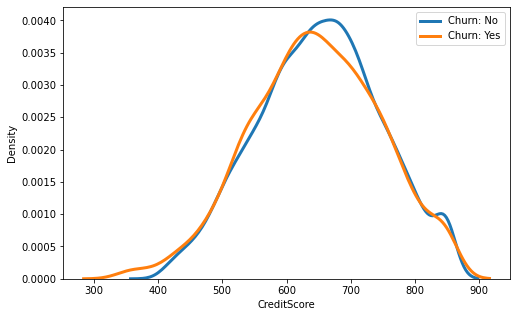

In [11]:
numeric_hist('CreditScore', True, False)

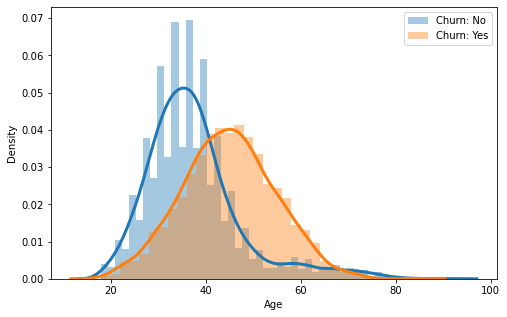

In [12]:
numeric_hist('Age', True, True)

Middle aged people are more likely to churn than the people in their 30s.

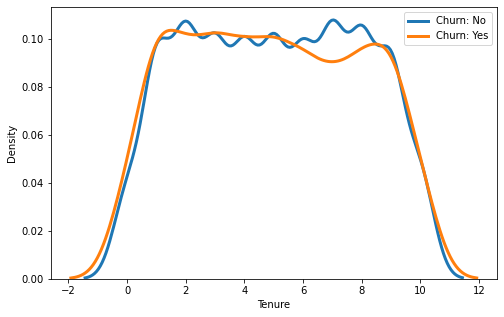

In [13]:
numeric_hist('Tenure', True, False)

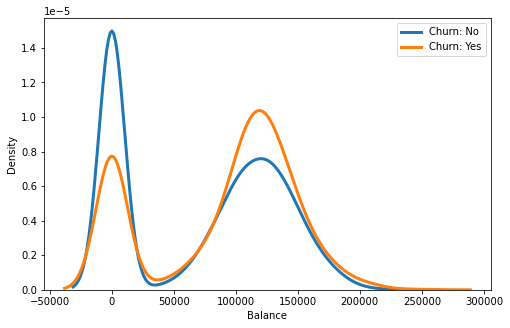

In [14]:
numeric_hist('Balance', True, False)

It's strange that the ones having the balance between 100,000 and 150,000 are more likely to churn. 

In [15]:
# Dropping the columns we won't need

dtset.drop(['RowNumber', 'CustomerId', 'Surname'], inplace=True, axis=1)

In [16]:
# Concatenate the dummy gender and geography feature dataframes

X = dtset.iloc[:,:-1]
y = dtset.iloc[:,-1]
X = pd.concat([X, gender, geography], axis=1)
X.drop(['Gender', 'Geography'], axis=1, inplace=True)

In [17]:
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Male,Germany,Spain
0,619,42,2,0.00,1,1,1,101348.88,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1


### XGBoost implementation   

In [18]:
# define the hyperparameters

params = {
    'max_depth':[4,5,6,7,8,9,10,11,12,13,14],
    'learning_rate':[1e-3, 1e-2, 1e-1, 2e-2, 2e-1, 3e-2, 3e-1, 4e-2, 4e-1],
    'min_child_weight':[1,3,5,7,9],
    'gamma':[0.0, 1e-1, 2e-1, 3e-1],
    'colsample_bytree':[0.1,0.3,0.5,0.7]
}

In [19]:
xgbst = xgboost.XGBClassifier()

In [20]:
model = RandomizedSearchCV(xgbst, param_distributions=params, n_iter=5, scoring="roc_auc", n_jobs=-1, cv=5, verbose=3)

In [21]:
model.fit(X, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:    4.7s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:    5.5s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    5.6s finished


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                      

In [22]:
model.best_params_

{'min_child_weight': 5,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 0.0,
 'colsample_bytree': 0.5}

In [23]:
model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [24]:
# Fit the model with the best parameters

best_classifier = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                              colsample_bynode=1, colsample_bytree=0.7, gamma=0.0, gpu_id=-1,
                              importance_type='gain', interaction_constraints='',
                              learning_rate=0.03, max_delta_step=0, max_depth=4,
                              min_child_weight=5, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
score = cross_val_score(best_classifier, X, y, cv=10)
score = np.mean(score)
print(score)

0.8612


86.12% accuracy isn't that bad. But, let's see if Deep Learning can improve it.

### Deep Learning implementation 

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize the features for faster convergence
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

In [54]:
classifier = Sequential()

# Add the input layer with dropout
classifier.add(Dense(6, kernel_initializer='he_uniform', activation='relu', input_dim=11))
classifier.add(Dropout(0.1))

# Hidden layer with dropout
classifier.add(Dense(6, kernel_initializer='he_uniform', activation='relu'))
classifier.add(Dropout(0.1))

# Output layer
classifier.add(Dense(1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

In [40]:
# Using accuracy as the metric and adam optimizer (Obviously)
classifier.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
model_history = classifier.fit(X_train, y_train, validation_split=0.20, batch_size = 10, epochs = 100)

Epoch 1/100
640/640 [==============================] - 1s 2ms/step - loss: 0.5530 - accuracy: 0.7856 - val_loss: 0.4888 - val_accuracy: 0.7969
Epoch 2/100
640/640 [==============================] - 1s 2ms/step - loss: 0.4904 - accuracy: 0.7931 - val_loss: 0.4620 - val_accuracy: 0.7969
Epoch 3/100
640/640 [==============================] - 1s 2ms/step - loss: 0.4649 - accuracy: 0.7956 - val_loss: 0.4493 - val_accuracy: 0.7969
Epoch 4/100
640/640 [==============================] - 1s 2ms/step - loss: 0.4576 - accuracy: 0.7944 - val_loss: 0.4424 - val_accuracy: 0.7969
Epoch 5/100
640/640 [==============================] - 1s 2ms/step - loss: 0.4516 - accuracy: 0.7952 - val_loss: 0.4388 - val_accuracy: 0.7969
Epoch 6/100
640/640 [==============================] - 1s 2ms/step - loss: 0.4490 - accuracy: 0.7955 - val_loss: 0.4366 - val_accuracy: 0.7969
Epoch 7/100
640/640 [==============================] - 1s 2ms/step - loss: 0.4408 - accuracy: 0.7958 - val_loss: 0.4353 - val_accuracy: 0.7969

Epoch 58/100
640/640 [==============================] - 1s 2ms/step - loss: 0.3999 - accuracy: 0.8134 - val_loss: 0.3834 - val_accuracy: 0.8144
Epoch 59/100
640/640 [==============================] - 1s 2ms/step - loss: 0.3996 - accuracy: 0.8134 - val_loss: 0.3801 - val_accuracy: 0.8150
Epoch 60/100
640/640 [==============================] - 1s 2ms/step - loss: 0.3919 - accuracy: 0.8148 - val_loss: 0.3797 - val_accuracy: 0.8144
Epoch 61/100
640/640 [==============================] - 1s 2ms/step - loss: 0.3963 - accuracy: 0.8152 - val_loss: 0.3761 - val_accuracy: 0.8175
Epoch 62/100
640/640 [==============================] - 1s 2ms/step - loss: 0.3957 - accuracy: 0.8142 - val_loss: 0.3798 - val_accuracy: 0.8138
Epoch 63/100
640/640 [==============================] - 1s 2ms/step - loss: 0.3946 - accuracy: 0.8156 - val_loss: 0.3785 - val_accuracy: 0.8144
Epoch 64/100
640/640 [==============================] - 1s 2ms/step - loss: 0.3940 - accuracy: 0.8141 - val_loss: 0.3758 - val_accuracy:

In [44]:
def plot_results(acc_or_loss):
    metric = acc_or_loss
    val_metric = 'val_'+metric
    plt.figure(figsize=(10,7))
    plt.plot(model_history.history[metric], label='train')
    plt.plot(model_history.history[val_metric], label='test')
    plt.title('Model {}'.format(metric))
    plt.xlabel('epoch')
    plt.ylabel('{}'.format(metric))
    plt.legend()

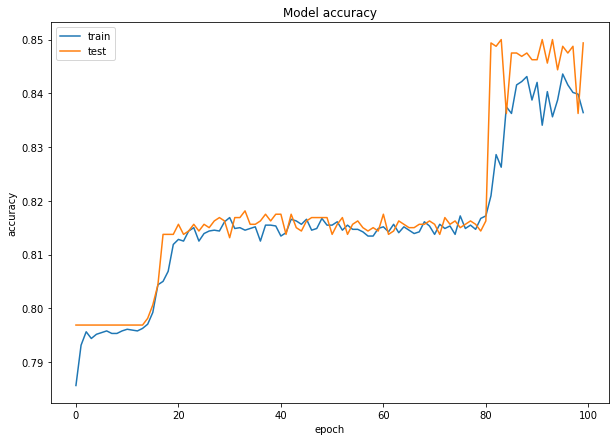

In [45]:
plot_results('accuracy')

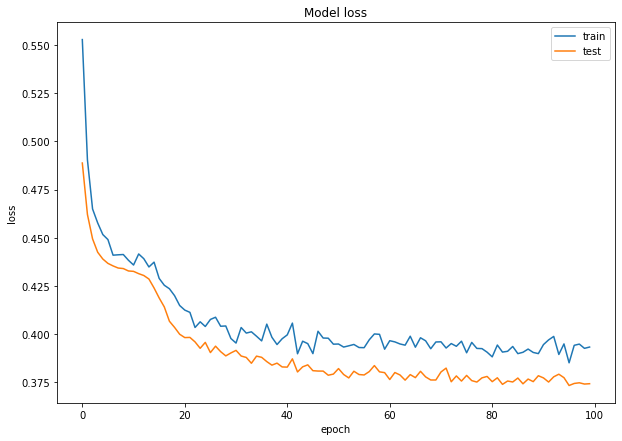

In [46]:
plot_results('loss')

In [47]:
y_pred = classifier.predict(X_test)

In [48]:
y_pred = (y_pred > 0.5)

In [50]:
print(accuracy_score(y_test, y_pred))

0.8635


A slightly better prediction than the XGBoost, but not significant

### Let's tune the hyperparameters using keras-tuner and check if accuracy can be improved further

In [96]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

In [97]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('no of layers', 2, 12)):
        model.add(layers.Dense(units=hp.Int('units_' +str(i),
                                            min_value=6,
                                           max_value=64,
                                           step=32),
                              activation='relu'))
        model.add(layers.Dense(1, activation='sigmoid'))
        model.compile(
            optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-1, 1e-2, 1e-3, 2e-2, 2e-1, 2e-3, 3e-2, 3e-1, 4e-2, 4e-1])),
            loss='binary_crossentropy',
            metrics=['accuracy'])
    return model

In [98]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='personal',
    project_name='ChurnPrediction')

In [99]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
no of layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 12, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 6, 'max_value': 64, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.02, 0.2, 0.002, 0.03, 0.3, 0.04, 0.4], 'ordered': True}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 6, 'max_value': 64, 'step': 32, 'sampling': None}


In [100]:
tuner.search(X_train, y_train,
             epochs=5,
             validation_data=(X_test, y_test))

Trial 5 Complete [00h 00m 11s]
val_accuracy: 0.7975000143051147

Best val_accuracy So Far: 0.8338333368301392
Total elapsed time: 00h 01m 05s
INFO:tensorflow:Oracle triggered exit


In [101]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [102]:
model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train, epochs = 5, validation_data = (X_test, y_test))

Epoch 1/5
250/250 [==============================] - 1s 3ms/step - loss: 0.4851 - accuracy: 0.7905 - val_loss: 0.4248 - val_accuracy: 0.7975
Epoch 2/5
250/250 [==============================] - 1s 2ms/step - loss: 0.4081 - accuracy: 0.7964 - val_loss: 0.3975 - val_accuracy: 0.7975
Epoch 3/5
250/250 [==============================] - 1s 2ms/step - loss: 0.3960 - accuracy: 0.8240 - val_loss: 0.3716 - val_accuracy: 0.8525
Epoch 4/5
250/250 [==============================] - 1s 2ms/step - loss: 0.3782 - accuracy: 0.8524 - val_loss: 0.3986 - val_accuracy: 0.8100
Epoch 5/5
250/250 [==============================] - 1s 2ms/step - loss: 0.3726 - accuracy: 0.8472 - val_loss: 0.3794 - val_accuracy: 0.8300


Nope, looks like XGBoost is the most efficient one yet giving good results.